# Machine Learning - Decision Trees and Ensemble Learning

## Decision Trees:
Decision trees are a versatile tool in machine learning for classification and regression tasks. They mimic human decision-making by creating a flowchart-like structure to make predictions based on input features.

## Goal

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

### Dataset

In [ ]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

### Prepare the dataset

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2 we are going to use all columns of the dataset.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

**Preparation:**

- Fill missing values with zeros.
- Apply the log tranform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [18]:
# load the data from housing.csv into a Pandas dataframe
df = pd.read_csv('housing.csv')

# keep only records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

# fill in the missing values with zeros
df = df.fillna(0)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


In [19]:
# apply log transform to median_house_value
features = 'median_house_value'
df[features] = np.log1p(df[features])

# split the data in train/val/test sets, with 60%/20%/20% distribution with seed 1
# .2 splits the data into 80% train and 20% test
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
#.25 splits the 80% train into 60% train and 20% val
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# reset the indexes of the dataframes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# separate the target variable from the train/val/test sets
y_train = df_train[features].values
y_val = df_val[features].values
y_test = df_test[features].values

# Separate features and target
train_features = df_train.drop(features, axis=1)
val_features = df_val.drop(features, axis=1)
test_features = df_test.drop(features, axis=1)

In [20]:
# Convert dataframes to dictionaries
train_dict = train_features.to_dict(orient='records')
val_dict = val_features.to_dict(orient='records')
test_dict = test_features.to_dict(orient='records')

# Initialize DictVectorizer
dv = DictVectorizer(sparse=True)

# Transform features using DictVectorizer
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

# Print the shapes of transformed data
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (9411, 10)
X_val shape: (3138, 10)
X_test shape: (3138, 10)


## Question 1 - Which feature is used for splitting the data?
Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1

- ocean_proximity
- total_rooms
- latitude
- population

In [21]:
# Train a decision tree regressor with max_depth=1
model = DecisionTreeRegressor(max_depth=1, random_state=1)
model.fit(X_train, y_train)

# Get the feature used for splitting
splitting_feature = train_features.columns[model.tree_.feature[0]]
print('The feature used for splitting:', splitting_feature)

The feature used for splitting: population


In [22]:
# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = rf_model.predict(X_val)

print (f' pred {y_val_pred[:5]} \n target {y_val[:5]}')

rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f'RMSE on validation: {rmse}')


 pred [12.23651651 12.09841222 11.58549383 12.08792117 12.31897298] 
 target [12.09122841 12.14153946 11.47834437 11.94015859 12.36734505]
RMSE on validation: 0.24501215124257716


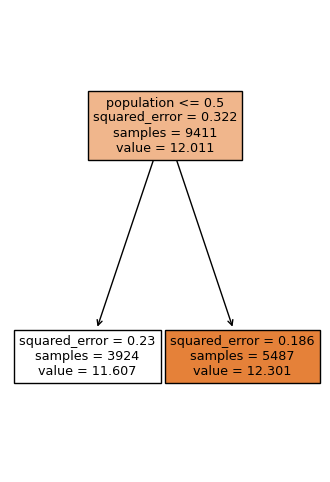

In [28]:
import matplotlib.pyplot as plt
from sklearn import tree
# Plot the decision tree
fig, ax = plt.subplots(figsize=(4, 6))
tree.plot_tree(model, feature_names=df_train.columns, filled=True, ax=ax)
plt.show()


## Question 3 - After which value of n_estimators does RMSE stop improving?
Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?

- 10
- 25
- 50
- 160

In [24]:
# Experiment with estimators
estimators = list(range(10, 200, 10))
rmse_values = []

for n in estimators:
    rf_model = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_val_pred = rf_model.predict(X_val)
    rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    rmse_values.append(rmse)
    print(f'n:{n},RMSE={rmse}')


n:10,RMSE=0.24501215124257722
n:20,RMSE=0.23909763288315677
n:30,RMSE=0.23694588128593366
n:40,RMSE=0.23524661060552132
n:50,RMSE=0.235289350622327
n:60,RMSE=0.23499205951298469
n:70,RMSE=0.2348703148073134
n:80,RMSE=0.23497451072905481
n:90,RMSE=0.23486712375821453
n:100,RMSE=0.23457854834306097
n:110,RMSE=0.23462470952704859
n:120,RMSE=0.23441395173165278
n:130,RMSE=0.23430827200449425
n:140,RMSE=0.2339938362049157
n:150,RMSE=0.23386041163827953
n:160,RMSE=0.2338111426011963
n:170,RMSE=0.23377406449040083
n:180,RMSE=0.23387911064045555
n:190,RMSE=0.23410707577682208
n:200,RMSE=0.23397064690003722
Best estimators: 170, Best RMSE: 0.23377406449040083


Best estimators: 170, Best RMSE: 0.23377406449040083


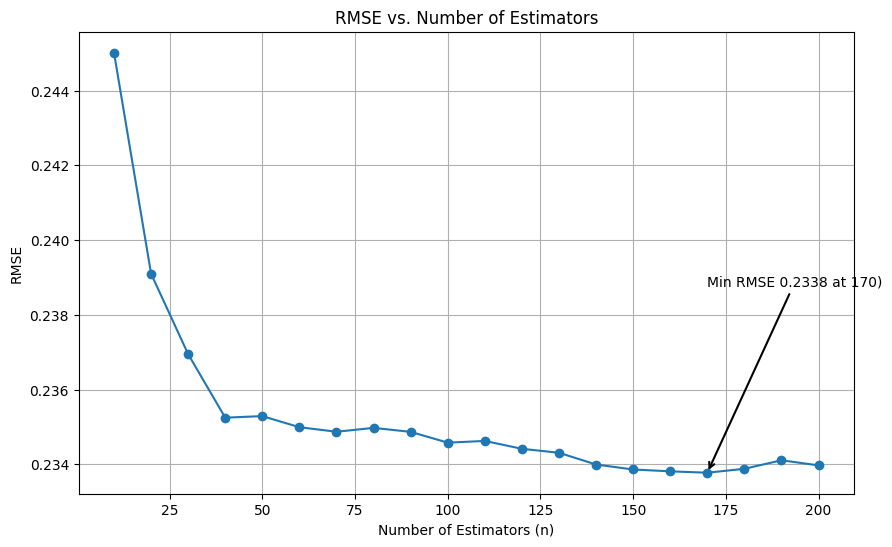

In [48]:
# Find the point where RMSE stops improving
min_rmse = min(rmse_values)
best_estimator = estimators[rmse_values.index(min_rmse)]
print(f'Best estimators: {best_estimator}, Best RMSE: {min_rmse}')

# Plot the RMSE values against the estimators values
plt.figure(figsize=(10, 6))
plt.plot(estimators, rmse_values, marker='o')
plt.xlabel('Number of Estimators (n)')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Estimators')
plt.grid(True)

# Add label for the minimum RMSE point
plt.annotate(f'Min RMSE {min_rmse:.4f} at {best_estimator})', xy=(best_estimator, min_rmse), 
             xytext=(best_estimator, min_rmse + 0.005),
             arrowprops=dict(arrowstyle='->', lw=1.5))

plt.show()